# Counting Jumps

Using g-force, counting jumps are the points where the force hits- or approaches (for a quick jump) zero.

Using Dec 30, 2023 data since only 2 runs registered (easy):

In [16]:
import matplotlib.pyplot as plt
from load import load_2023_12_30
from signal_processing import lowpass, length, indicesUnderTH
from sync import splitTileIntoDownhillTracks, syncTile
from tile import Tile

In [17]:
a50_2023_12_30, a50_all_2023_12_30, f6p_2023_12_30, tile_2023_12_30 = load_2023_12_30()

In [18]:
tile_2023_12_30_sync = syncTile(
    tile=tile_2023_12_30,
    truth=a50_all_2023_12_30,
    printOutput=True,
    # use_mae=False,
    time_step_s=0.5,
    max_time_search_s=30,
    alt_step=0.25,
    min_alt_start=120,
    max_alt_search=140)

Timestamp offset: 8000
Altitude offset: 131.75


In [19]:
tile_2023_12_30_runs = splitTileIntoDownhillTracks(tile_2023_12_30_sync, a50_2023_12_30)
print('Run count:', len(tile_2023_12_30_runs))

[[1703955989, 1703956104], [1703956733, 1703956847], [1703956907, 1703956947]]
Run count: 3


In [20]:
run1 = tile_2023_12_30_runs[0]
run2 = tile_2023_12_30_runs[1]

In [21]:
jump_mg_th = 600

run1_jumps = indicesUnderTH(run1.mG_lpf, jump_mg_th)
print('Run1')
print(len(run1_jumps), 'Jump(s):', run1_jumps)

run2_jumps = indicesUnderTH(run2.mG_lpf, jump_mg_th)
print('Run2')
print(len(run2_jumps), 'Jump(s):', run2_jumps)

Run1
94 Jump(s): [5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130]
Run2
1 Jump(s): [6649]


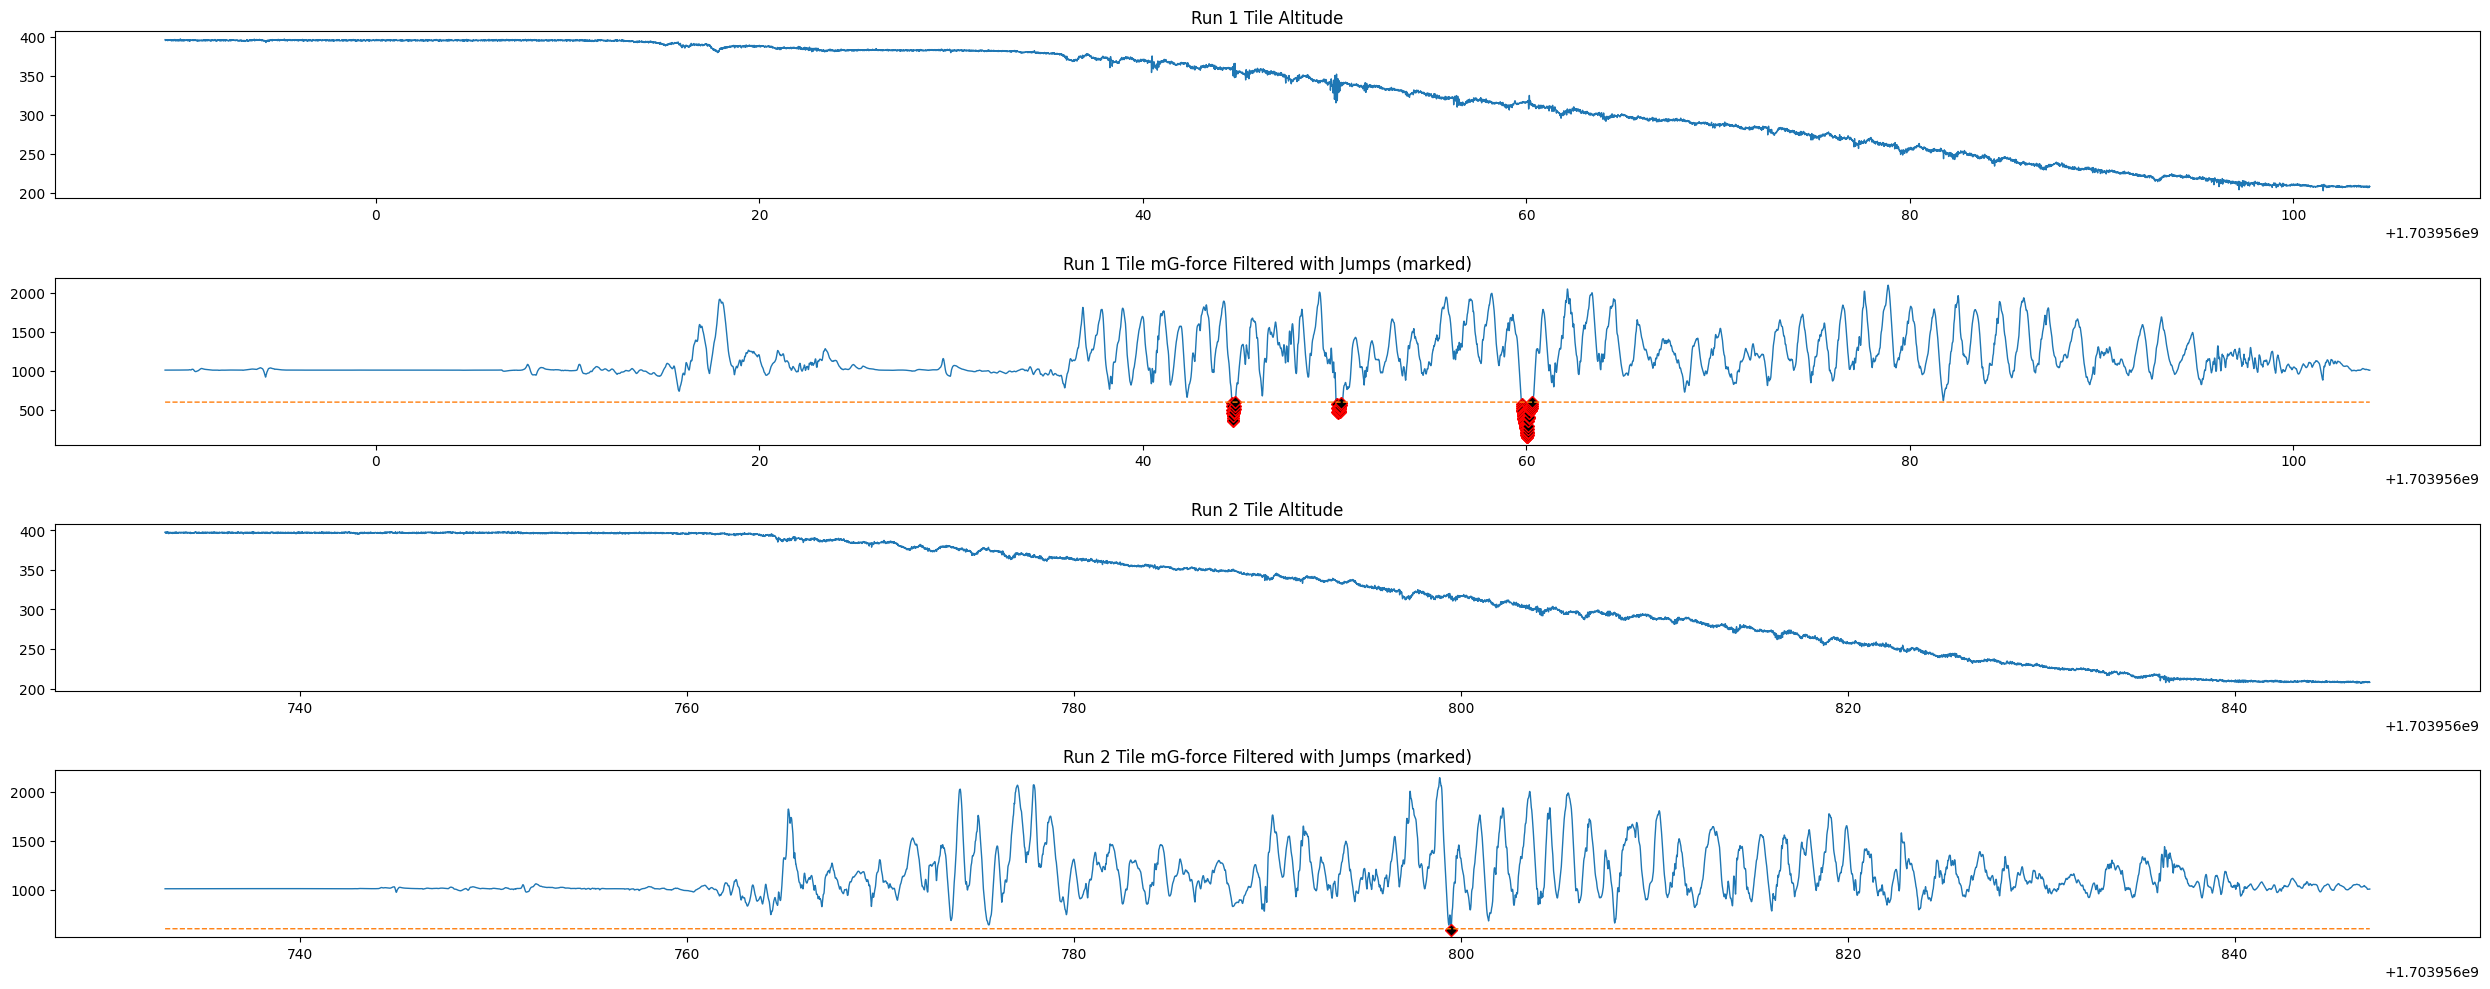

In [22]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(4, figsize=(25, 10))
ax[0].plot(run1.time, run1.alt)
ax[0].set_title('Run 1 Tile Altitude', wrap=True)

ax[1].plot(run1.time, run1.mG_lpf, '-D', markevery=run1_jumps, mfc='k', mec='red')
ax[1].plot(run1.time, [jump_mg_th for _ in run1.mG_lpf], '--')
ax[1].set_title('Run 1 Tile mG-force Filtered with Jumps (marked)', wrap=True)

ax[2].plot(run2.time, run2.alt)
ax[2].set_title('Run 2 Tile Altitude', wrap=True)

ax[3].plot(run2.time, run2.mG_lpf, '-D', markevery=run2_jumps, mfc='k', mec='red')
ax[3].plot(run2.time, [jump_mg_th for _ in run2.mG_lpf], '--')
ax[3].set_title('Run 2 Tile mG-force Filtered with Jumps (marked)', wrap=True)

plt.tight_layout()
plt.show()

### Spot the Landing(s)!

Plot with the unfiltered acceleration magnitude, since the frequency is filtered out in the g-force signal. Use this confirm a large impulse happens after the near-zero-g to represent the landing.

In [25]:
def plotJumpAnalysis(run: Tile, x1, x2):
    mg_raw = length(run.ax, run.ay, run.az)
    mg_filt = run.mG_lpf
    gyro = length(run.gx, run.gy, run.gz)

    min_idx = run.time[x1:x2][mg_filt[x1:x2].index(min(mg_filt[x1:x2]))]

    plt.rc('lines', linewidth=1)
    _, ax = plt.subplots(3, figsize=(15, 5))

    ax[0].plot(run.time[x1:x2], mg_filt[x1:x2])
    ax[0].plot(run.time[x1:x2], [jump_mg_th for _ in mg_filt[x1:x2]], '--')
    ax[0].axvline(x=min_idx, ls=':', color='k')
    ax[0].set_title('Run 1 Tile Filtered mG-force (600mG threshold)', wrap=True)

    ax[1].plot(run.time[x1:x2], mg_raw[x1:x2])
    ax[1].axvline(x=min_idx, ls=':', color='k')
    ax[1].set_title('Run 1 Tile Unfiltered mG-force', wrap=True)

    ax[2].plot(run.time[x1:x2], gyro[x1:x2])
    ax[2].axvline(x=min_idx, ls=':', color='k')
    ax[2].set_title('Run 1 Tile Unfiltered Gyroscope', wrap=True)
    
    plt.tight_layout()
    plt.show()

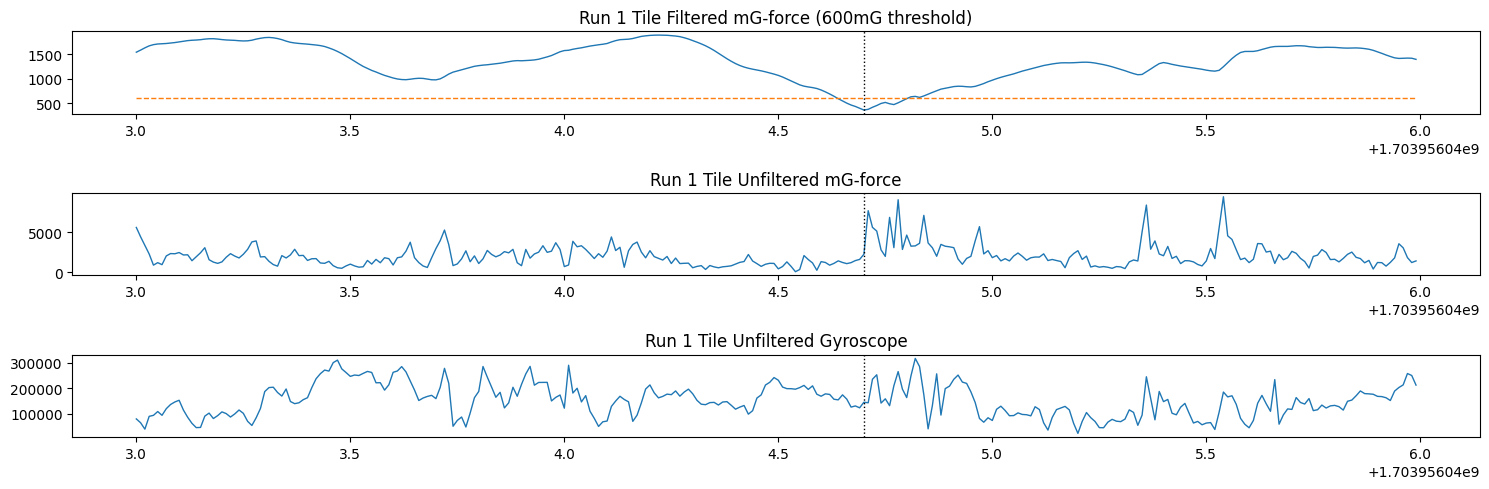

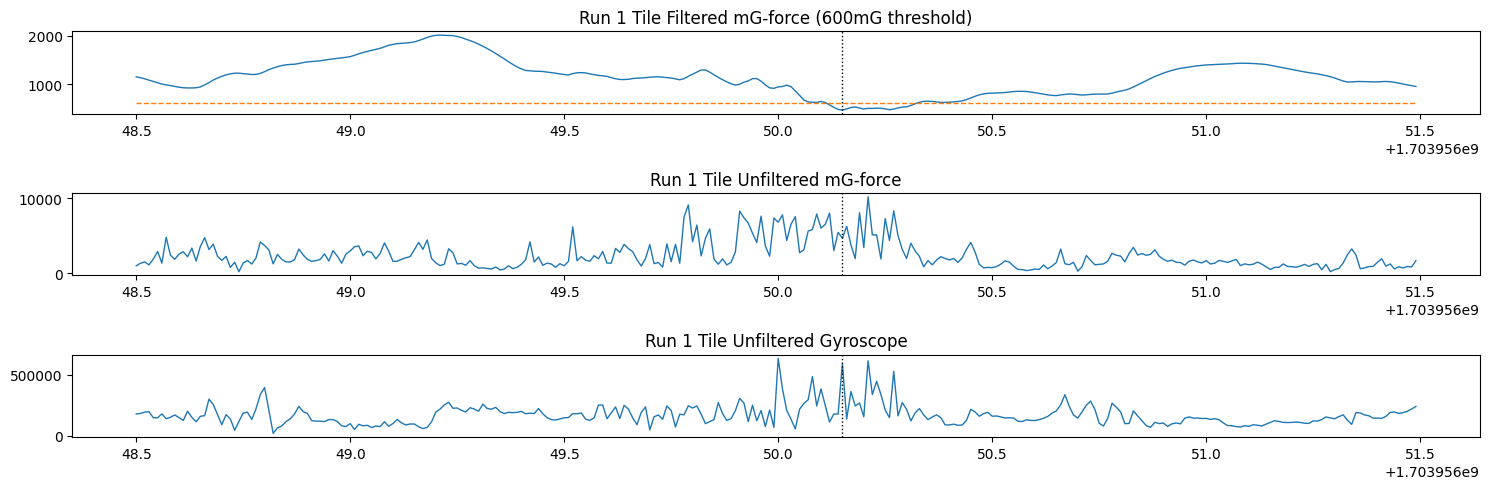

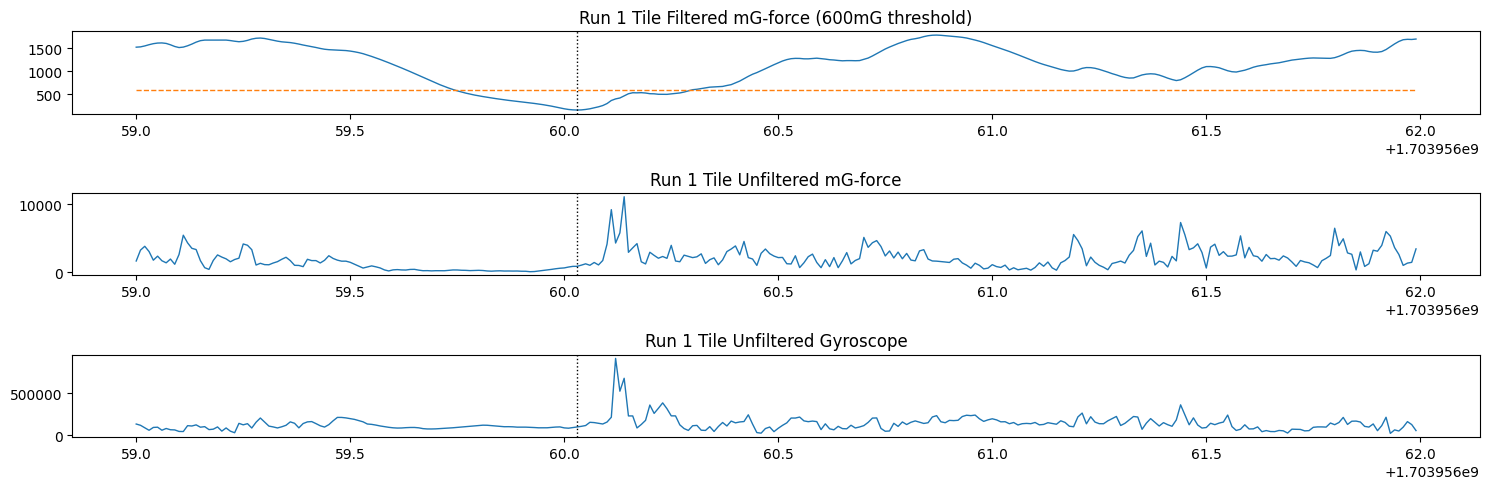

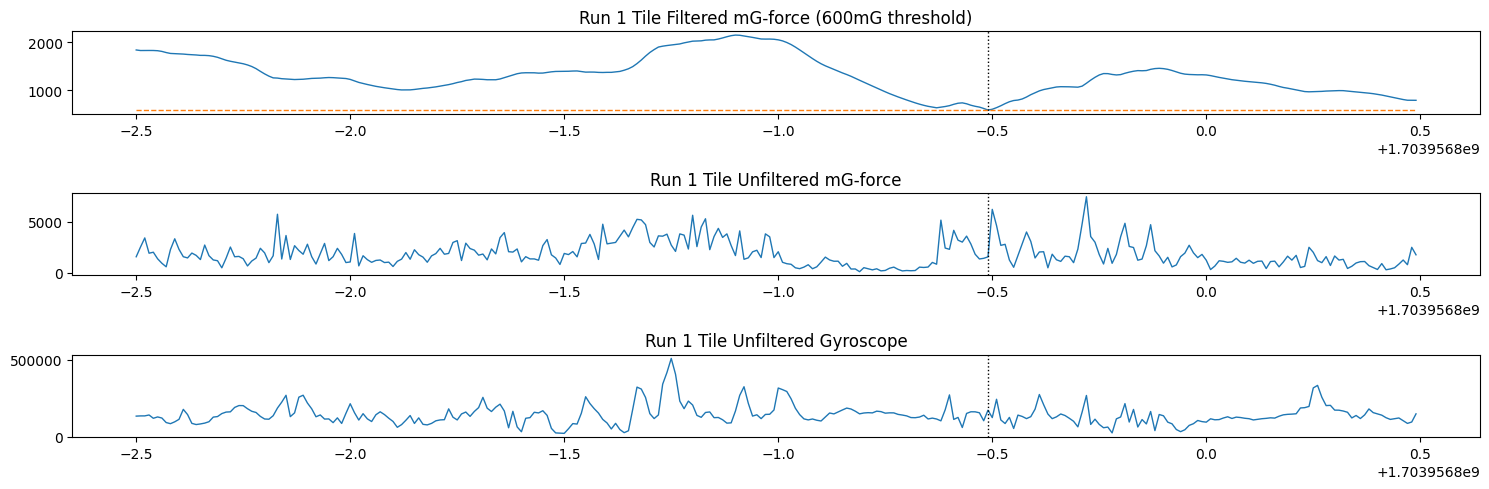

In [26]:
run1_jump1_x1 = 5400
run1_jump1_x2 = 5700
run1_jump2_x1 = 5950
run1_jump2_x2 = 6250
run1_jump3_x1 = 7000
run1_jump3_x2 = 7300

run2_jump1_x1 = 6450
run2_jump1_x2 = 6750

plotJumpAnalysis(run1, run1_jump1_x1, run1_jump1_x2)
plotJumpAnalysis(run1, run1_jump2_x1, run1_jump2_x2)
plotJumpAnalysis(run1, run1_jump3_x1, run1_jump3_x2)
plotJumpAnalysis(run2, run2_jump1_x1, run2_jump1_x2)

### Recognition Steps

Based on these results, the steps to determine whether a jump occured using just g-force are:

- identify areas of sequential points below the 200mg threshold
  - small number of points below the threshold may not indicate jump
- use the ts of these sequential points to test whether the filtered g-force saw a strong decreasing trend before the min
- use the ts of these sequential points to test whether the signals saw low values and noise (before the min):
  - unfiltered g-force
  - unfiltered gyroscope magnitude
- use the ts again to test whether a large impulse was detected after the min:
  - unfiltered g-force
  - unfiltered gyroscope magnitude

Combining these can offer a score on whether a jump is detected. Condluing from the data, jumps:

1. controversial, small jump
2. not a jump
3. jump
4. controversial, small jump


> Note: You could mark these results and train a nn on jump detection instead of this analytic approach